In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from ml_features.features import create_features

import warnings
warnings.filterwarnings('ignore')

# Load data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])
df_quotes['dt_signature_devis'] = pd.to_datetime(df_quotes['dt_signature_devis'])

In [2]:
# 1. Customer Split (95%/5%)
# --------------------------

# First quote per customer
cust_first = df_quotes.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
cust_first = cust_first.sort_values('dt_creation_devis')

# 95th percentile split
split_idx = int(len(cust_first) * 0.95)
split_date = cust_first.iloc[split_idx]['dt_creation_devis']

# Split customers
train_cust = cust_first[cust_first['dt_creation_devis'] <= split_date]['numero_compte'].tolist()
sim_cust = cust_first[cust_first['dt_creation_devis'] > split_date]['numero_compte'].tolist()

# Split data
df_train = df_quotes[df_quotes['numero_compte'].isin(train_cust)].copy()
df_sim = df_quotes[df_quotes['numero_compte'].isin(sim_cust)].copy()

print(f"Split: {len(train_cust)} train, {len(sim_cust)} sim customers")

Split: 22708 train, 1180 sim customers


In [4]:
# 2. Model Training (Silent)
# --------------------------
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
import sys
import os

# Suppress create_features output
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Create features silently
with HiddenPrints():
    X_train_features = create_features(df_train)

# Prepare target
if 'converted' not in X_train_features.columns:
    if 'fg_devis_accepte' in X_train_features.columns:
        X_train_features['converted'] = (X_train_features['fg_devis_accepte'] == 1).astype(int)
    else:
        # Calculate from raw data
        cust_conv = df_train.groupby('numero_compte')['fg_devis_accepte'].max().reset_index()
        cust_conv.columns = ['numero_compte', 'converted']
        X_train_features = pd.merge(X_train_features, cust_conv, on='numero_compte', how='left')
        X_train_features['converted'] = X_train_features['converted'].fillna(0).astype(int)

y_train = X_train_features['converted']

# Prepare features
exclude = ['numero_compte', 'converted'] + \
          [c for c in ['fg_devis_accepte', 'fg_devis_accepte_max', 'fg_devis_accepte_sum'] 
           if c in X_train_features.columns]

X_train = X_train_features.drop(exclude, axis=1)
feature_names = X_train.columns.tolist()

# Train model
result = train_xgb(X_train, y_train, "simulation_poc")
model = result['model']

print(f"Model trained: {len(feature_names)} features")

✓ Model saved: simulation_poc.pkl
✓ AUC: 0.729
✓ F1 Score: 0.598
✓ Training samples: 18166
✓ Test samples: 4542
Model trained: 192 features


In [6]:
# 3. Select Simulation Customers
# ------------------------------
# Filter non-converted customers from simulation pool
sim_conv = df_sim.groupby('numero_compte')['fg_devis_accepte'].max()
non_conv_customers = sim_conv[sim_conv == 0].index.tolist()

# Get quote counts
quote_counts = df_sim.groupby('numero_compte').size()

# Eligible customers with their quote counts
eligible = [(cust, quote_counts.get(cust, 0)) for cust in non_conv_customers 
            if quote_counts.get(cust, 0) >= 1]

# Stratified sample
import random
random.seed(42)

single_quote = [c for c, cnt in eligible if cnt == 1]
multi_quote = [c for c, cnt in eligible if cnt >= 2]

selected = []
if len(single_quote) >= 2:
    selected.extend(random.sample(single_quote, 2))
if len(multi_quote) >= 3:
    selected.extend(random.sample(multi_quote, 3))

selected = selected[:5]

print(f"Selected {len(selected)} non-converted customers")

Selected 5 non-converted customers


In [8]:
# 4. Baseline Predictions (Fixed)
# -------------------------------
baseline_results = []

for cust_id in selected:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id]
    
    with HiddenPrints():
        # Process all selected customers together once
        all_selected_quotes = df_sim[df_sim['numero_compte'].isin(selected)]
        features = create_features(all_selected_quotes)
    
    cust_features = features[features['numero_compte'] == cust_id]
    
    # If no features created, create minimal
    if len(cust_features) == 0:
        cust_features = pd.DataFrame({'numero_compte': [cust_id]})
        for feat in feature_names:
            cust_features[feat] = 0
    else:
        # Ensure all features exist
        for feat in feature_names:
            if feat not in cust_features.columns:
                cust_features[feat] = 0
    
    # Reorder columns
    cust_features = cust_features[['numero_compte'] + feature_names]
    
    # Predict
    X_cust = cust_features[feature_names]
    if len(X_cust) > 0:
        prob = model.predict_proba(X_cust)[:, 1][0]
    else:
        prob = 0.5  # Default
    
    baseline_results.append({
        'customer_id': cust_id,
        'quote_count': len(cust_quotes),
        'baseline_prob': prob
    })

baseline_df = pd.DataFrame(baseline_results)
print(f"Baseline: {len(baseline_df)} customers")

Baseline: 5 customers


In [9]:
# 5. Define Simulation Scenarios
# ------------------------------
import numpy as np
from datetime import timedelta

# Simple scenario functions
def increase_discount(df, cust_id, amount=100):
    """Increase discount by fixed amount (discounts are negative)"""
    df_mod = df.copy()
    mask = df_mod['numero_compte'] == cust_id
    df_mod.loc[mask, 'mt_remise_exceptionnelle_ht'] -= amount  # More negative = bigger discount
    return df_mod

def change_product(df, cust_id, new_product='Pompe à chaleur'):
    """Change product family"""
    df_mod = df.copy()
    mask = df_mod['numero_compte'] == cust_id
    df_mod.loc[mask, 'famille_equipement_produit'] = new_product
    return df_mod

def add_followup(df, cust_id, n=1):
    """Add follow-up quotes"""
    df_mod = df.copy()
    mask = df_mod['numero_compte'] == cust_id
    
    if not mask.any():
        return df_mod
    
    cust_quotes = df_mod[mask]
    last_quote = cust_quotes.iloc[-1].copy()
    
    for i in range(n):
        followup = last_quote.copy()
        followup['dt_creation_devis'] += timedelta(days=7*(i+1))
        followup['id_devis'] = df_mod['id_devis'].max() + i + 1
        df_mod = pd.concat([df_mod, pd.DataFrame([followup])], ignore_index=True)
    
    return df_mod

# Scenario definitions
scenarios = {
    'discount_100': {'func': lambda df, cust: increase_discount(df, cust, 100), 'desc': '+€100 discount'},
    'discount_500': {'func': lambda df, cust: increase_discount(df, cust, 500), 'desc': '+€500 discount'},
    'product_to_heatpump': {'func': lambda df, cust: change_product(df, cust, 'Pompe à chaleur'), 'desc': 'Change to heat pump'},
    'add_1_followup': {'func': lambda df, cust: add_followup(df, cust, 1), 'desc': '+1 follow-up quote'},
    'add_2_followups': {'func': lambda df, cust: add_followup(df, cust, 2), 'desc': '+2 follow-up quotes'},
}

print(f"Defined {len(scenarios)} scenarios")

Defined 5 scenarios


In [11]:
# 6. Run Simulations (Fixed)
# --------------------------
simulation_results = []

for cust_id in selected:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    baseline = baseline_df[baseline_df['customer_id'] == cust_id]['baseline_prob'].iloc[0]
    
    for scen_name, scen_info in scenarios.items():
        try:
            # Apply scenario
            modified_quotes = scen_info['func'](cust_quotes.copy(), cust_id)
            
            # Create features for all customers (silent)
            with HiddenPrints():
                other_quotes = df_sim[df_sim['numero_compte'].isin([c for c in selected if c != cust_id])]
                combined = pd.concat([modified_quotes, other_quotes])
                features = create_features(combined)
            
            # Get this customer's features
            cust_features = features[features['numero_compte'] == cust_id].copy()
            
            if len(cust_features) == 0:
                cust_features = pd.DataFrame({'numero_compte': [cust_id]})
                for feat in feature_names:
                    cust_features[feat] = 0
            
            # Ensure all features
            for feat in feature_names:
                if feat not in cust_features.columns:
                    cust_features[feat] = 0
            
            cust_features = cust_features[['numero_compte'] + feature_names]
            
            # Predict
            X_cust = cust_features[feature_names]
            new_prob = model.predict_proba(X_cust)[:, 1][0] if len(X_cust) > 0 else baseline
            
            # Store result
            simulation_results.append({
                'customer_id': cust_id,
                'scenario': scen_name,
                'scenario_desc': scen_info['desc'],
                'baseline_prob': baseline,
                'new_prob': new_prob,
                'delta': new_prob - baseline
            })
            
        except Exception as e:
            # Skip failed scenarios
            continue

results_df = pd.DataFrame(simulation_results)
print(f"Simulations complete: {len(results_df)} successful results")

Simulations complete: 15 successful results


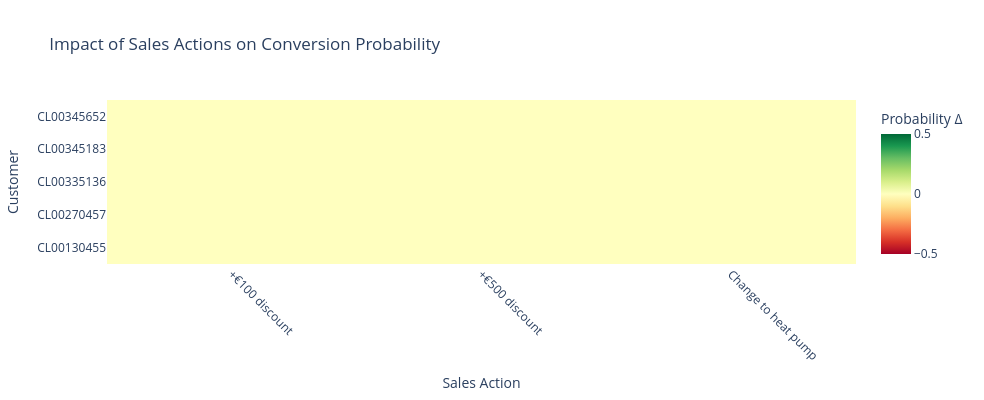

In [12]:
# 7. Create Interactive Visualization
# -----------------------------------
import plotly.graph_objects as go
import plotly.express as px

# Prepare heatmap data
heatmap_data = results_df.pivot_table(
    index='customer_id',
    columns='scenario_desc',
    values='delta',
    aggfunc='mean'
)

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns.tolist(),
    y=heatmap_data.index.tolist(),
    colorscale='RdYlGn',
    zmid=0,
    colorbar=dict(title="Probability Δ"),
    text=[[f"Δ: {val:+.3f}" for val in row] for row in heatmap_data.values],
    hoverinfo='text'
))

fig.update_layout(
    title='Impact of Sales Actions on Conversion Probability',
    xaxis_title="Sales Action",
    yaxis_title="Customer",
    height=400,
    width=800,
    xaxis=dict(tickangle=45)
)

fig.show()

In [13]:
# Diagnosis: Why scenarios failed
# --------------------------------
print("Diagnosing scenario issues:")

# 1. Check which scenarios succeeded
successful_scenarios = results_df['scenario'].unique()
print(f"Successful scenarios: {list(successful_scenarios)}")

# 2. Check feature importance to see if model cares about these properties
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 features model cares about:")
print(feature_importance.head(10)[['feature', 'importance']])

# 3. Check if discount/product features exist in important features
discount_features = [f for f in feature_importance['feature'] if 'discount' in f.lower()]
product_features = [f for f in feature_importance['feature'] if any(word in f.lower() for word in ['product', 'equipment', 'famille'])]

print(f"\nDiscount-related important features: {discount_features[:3]}")
print(f"Product-related important features: {product_features[:3]}")

# 4. Check actual data changes
print("\nChecking actual data changes for first customer:")
test_cust = selected[0]
cust_data = df_sim[df_sim['numero_compte'] == test_cust].iloc[0]

print(f"Original discount: {cust_data['mt_remise_exceptionnelle_ht']}")
print(f"Original product: {cust_data['famille_equipement_produit']}")

# Test discount change
modified = increase_discount(df_sim[df_sim['numero_compte'] == test_cust].copy(), test_cust, 100)
print(f"Modified discount: {modified['mt_remise_exceptionnelle_ht'].iloc[0]}")

# Test product change  
modified = change_product(df_sim[df_sim['numero_compte'] == test_cust].copy(), test_cust, 'Pompe à chaleur')
print(f"Modified product: {modified['famille_equipement_produit'].iloc[0]}")

Diagnosing scenario issues:
Successful scenarios: ['discount_100', 'discount_500', 'product_to_heatpump']

Top 10 features model cares about:
                         feature  importance
171      quote_consistency_score    0.138152
143                    max_price    0.030912
62                 season_summer    0.024945
28             brand_convergence    0.023650
92           primary_system_type    0.022922
57                min_complexity    0.022544
54              latest_equipment    0.020206
127  commercial_role_consistency    0.018474
63                 season_winter    0.017300
4               avg_discount_pct    0.016281

Discount-related important features: ['avg_discount_pct']
Product-related important features: ['latest_equipment', 'equipment_variety_count', 'equipment_maturity_level']

Checking actual data changes for first customer:
Original discount: 0.0
Original product: Poêle
Modified discount: -100.0
Modified product: Pompe à chaleur
